In [1]:
import random
from tqdm import tqdm
import os
import glob
from PIL import Image, ImageFile
import numpy as np

import torch.utils.data as data

import torch
from torch.autograd import Function
import torch.optim as optim

from torchvision import transforms
import matplotlib.pyplot as plt


import torch.nn as nn
import torchvision.models as models
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50 = torch.nn.Sequential(*(list(model_resnet50.children())[:-1]))

/home/sayan/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/sayan/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from pcgrad import PCGrad

In [3]:
def file_list(data_dir):

    # list of image files and corresponding labels
    files_list = []
    x = os.walk(data_dir, topdown=False)
    j=-1
    for path,d,filelist in sorted(x):
        if j !=-1:
            kkk=path.split(os.sep)
            label_name = kkk[-1]
            
            for filename in sorted(filelist):

                file_glob = os.path.join(path, filename)
                files_list.extend([(glob.glob(file_glob),j, label_name)])
                          
        j=j+1
    print(j)

    return files_list

In [4]:
class data_loader_single(data.Dataset):
    def __init__(self, dataset):
        
        self.dataset = dataset
        
        mean_pix = [0.485, 0.456, 0.406]
        std_pix = [0.229, 0.224, 0.225]
        normalize = transforms.Normalize(mean=mean_pix, std=std_pix)
        
        self.transformer_src = transforms.Compose([transforms.Resize(256),
                                                transforms.RandomCrop(224),
                                                transforms.ToTensor(),
                                                normalize])
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        return_val = []
               
        source_img = Image.open(self.dataset[index][0][0]).convert('RGB')
        source_label = torch.tensor(self.dataset[index][1], dtype=torch.long)
        source_img = self.transformer_src(source_img)
        image_label_name = self.dataset[index][2]
        
        return_val.append((source_img, source_label, image_label_name))
        
        return return_val

In [5]:
def dataset_loader(dataset1, 
                   batch_size=4, shuffle=True, 
                   drop_last=True):
    
    train_loader = data_loader_single(dataset1)
    loader_train = torch.utils.data.DataLoader(train_loader,batch_size=batch_size, 
                                                      shuffle=shuffle, drop_last=drop_last)
    
    return loader_train

In [6]:
from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

In [7]:
class Feature_Extractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            model_resnet50,
            nn.Flatten(start_dim=1, end_dim=-1)
        )
    def forward(self, x):
        x = self.network(x)
        return x

In [8]:
class DomainClassifier(nn.Module): # source classifier
    def __init__(self, input_dim):
        super(DomainClassifier, self).__init__()
        self.input_dim = input_dim
        self.numclasses = numclasses
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(input_dim, 100))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(100))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_fc2', nn.Linear(100, 2))
        self.domain_classifier.add_module('d_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha=1):
        
        reverse_feature = ReverseLayerF.apply(input_data, alpha)
        domain_output = self.domain_classifier(reverse_feature)

        return domain_output

In [9]:
class ClassClassifier(nn.Module): # source classifier
    def __init__(self, input_dim, numclasses):
        super(ClassClassifier, self).__init__()
        self.input_dim = input_dim
        self.numclasses = numclasses
        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(input_dim, 1024))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(1024))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout2d())
        self.class_classifier.add_module('c_fc2', nn.Linear(1024, 512))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(512))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(512, numclasses))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax())
        
    def forward(self, input_features):
        
        classifier_output = self.class_classifier(input_features)

        return classifier_output

In [10]:
def test(t_file_list, base_model, ClassClassifier):
    
    base_model.eval(), ClassClassifier.eval()
    
    test_dataLoader = dataset_loader(t_file_list, batch_size= 10, drop_last=False)
    
    with torch.no_grad():
        acc = 0
        
        for i, batch in enumerate(test_dataLoader):
            image = batch[0][0].to(device)
            label = batch[0][1]
            
            prob = ClassClassifier(base_model(image))            
            cl_pred=torch.argmax(prob.cpu(), dim = 1)
            acc += torch.sum(cl_pred == label).item()
            
        acc/=len(t_file_list)
            
        return acc
        

In [11]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

In [12]:
def training(root, dataset, base_model, classifier, discriminator, criterion, optimizer,Source, 
             target, device, num_epoch, save_path, batch_size, shuffle1, drop_last):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    base_model=base_model.to(device)
    base_model=base_model.train()
    
    classifier=classifier.to(device)
    classifier=classifier.train()
    
    discriminator=discriminator.to(device)
    discriminator=discriminator.train()
    
    
    criterion=criterion.to(device)
    
    loss_class = torch.nn.NLLLoss()
    loss_class = loss_class.to(device)
    
    loss_domain = torch.nn.NLLLoss()
    loss_domain = loss_domain.to(device)
    
    s1_path = os.path.join(root, dataset, Source)
    s1_file_list = file_list(s1_path)
    
    t_path = os.path.join(root, dataset, target)
    t_file_list = file_list(t_path)
    
    cl_loss_list = []
    d_loss_list = []
    
    for epoch in range(num_epoch):
        base_model=base_model.train()
        classifier=classifier.train()
        discriminator=discriminator.train()
        
        print("epoch___________________", epoch)
        step=0
        cl_loss_avg=0
        d_loss_avg = 0
        
        S1_dataload = dataset_loader(s1_file_list, batch_size= batch_size)
        
        t1_dataload = dataset_loader(t_file_list, batch_size= batch_size)
        
        n_batch_S = len(S1_dataload)
        #print(n_batch_S)
        s1_iter = iter(S1_dataload)
        #print(len(s1_iter))        
        
        n_batch_t = len(t1_dataload)
        t_iter = iter(t1_dataload)
        
        iteration = np.max([n_batch_S, n_batch_t])
        
        
        ### ________________________ iteration ___________________###
        
        for i in tqdm(range(iteration)):
            
            pp1 = float(i + epoch * iteration) / num_epoch / iteration
            alpha = 2. / (1. + np.exp(-10 * pp1)) - 1
            
            if step%n_batch_S == 0:
                s1_iter=iter(S1_dataload)
            batch_s1=next(s1_iter)        # S batch
                       
            if step%n_batch_t == 0:
                t_iter = iter(t1_dataload)  # target
            batch_t=next(t_iter)
            
            S1_f = batch_s1[0][0].float()
            S1_f = S1_f.to(device)
            S1_l = batch_s1[0][1].type(torch.LongTensor)
            S1_l = S1_l.to(device)
            #print(S1_l)
            
            t_f = batch_t[0][0].float()
            t_f = t_f.to(device)

            t_f_out = base_model(t_f)

            S1_f_out = base_model(S1_f) 

            t_f_out = base_model(t_f)
            
            # classifier output
            
            S1_out = classifier(S1_f_out)
            
            # Discriminator output
            
            S1_out_dis = discriminator(S1_f_out, alpha = alpha)
            t_out_dis = discriminator(t_f_out, alpha = alpha)
            
            s1_dis_l = torch.zeros(S1_out_dis.shape[0]).type(torch.LongTensor).to(device)
            t_dis_l = torch.ones(t_out_dis.shape[0]).type(torch.LongTensor).to(device)
            
            ## loss calculations
            
            
            cl_loss1 = loss_class(S1_out, S1_l)
            
            cl_loss_avg +=cl_loss1.item()
            
            d1_loss = criterion(S1_out_dis, s1_dis_l)
            d2_loss = criterion(t_out_dis, t_dis_l)
            
            d_loss = (d1_loss + d2_loss)/2
            #print(d_loss)
            d_loss_avg +=d_loss.item()
            
            #total_loss = cl_loss1 + d_loss
            
            total_loss = [cl_loss1, d_loss]
            
            
            
            #optimizer.zero_grad()
            
            optimizer.pc_backward(total_loss)
            
            #total_loss.backward() # backprop
            optimizer.step()
            
            step=step+1
        cl_loss_avg /= iteration
        d_loss_avg /= iteration
        dd=test(t_file_list, base_model, classifier)
        print(dd*100)
        cl_loss_list.append(cl_loss_avg.item())
        d_loss_list.append(d_loss_avg.item())
    my_plot(np.linspace(1, num_epoch, num_epoch).astype(int), cl_loss_list)
    my_plot(np.linspace(1, num_epoch, num_epoch).astype(int), d_loss_list)
            

In [14]:
## model input parameters
inputdim = 2048
hidden1_out = 1024
output_dim = 512

numclasses = 14

root = "/home/sayan/Desktop/code_2023/RS_data"
#root ="/home/sayan/Desktop/code_2023/RS_data/EarthonCanvas"
dataset = "EarthonCanvas"
source =  "Aerialsketch"
target = "AerialPhoto" 

14
14
epoch___________________ 0


  0%|                                                  | 0/350 [00:00<?, ?it/s]/home/sayan/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/home/sayan/anaconda3/envs/pytorch_gpu/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|████████████████████████████████████████| 350/350 [01:01<00:00,  5.68it/s]


39.313795568263046
epoch___________________ 1


100%|████████████████████████████████████████| 350/350 [01:00<00:00,  5.81it/s]


43.81701215153681
epoch___________________ 2


100%|████████████████████████████████████████| 350/350 [01:00<00:00,  5.80it/s]


47.748391708363116
epoch___________________ 3


100%|████████████████████████████████████████| 350/350 [01:00<00:00,  5.80it/s]


49.6783416726233
epoch___________________ 4


100%|████████████████████████████████████████| 350/350 [01:00<00:00,  5.79it/s]


46.31879914224446


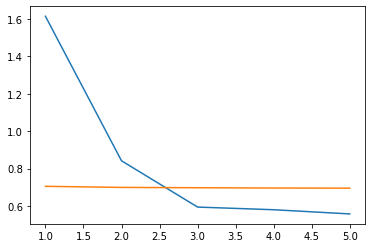

In [15]:
base_model = Feature_Extractor()
classifier = ClassClassifier(inputdim, numclasses)
discriminator = DomainClassifier(inputdim)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001

params = list(base_model.parameters()) + list(classifier.parameters()) + list(discriminator.parameters())
#optimizer = torch.optim.Adam(params, lr=learning_rate)

optimizer = PCGrad(optim.Adam(params, lr=learning_rate))

shuffle1=True
drop_last = True
batch_size = 4

device = "cuda" if torch.cuda.is_available() else "cpu"
num_epoch= 5
save_path="./save_model"

###################################

training(root, dataset, base_model, classifier, discriminator, criterion, optimizer,source, target, 
             device, num_epoch, save_path, batch_size, shuffle1, drop_last)

In [ ]:
cl_loss_list